In [2]:
!pip install -U sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=65709bec9ba02af8f0730614f01e468732ad4e738f570e070777d8d7be146ae8
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [3]:
import pandas as pd
import os 
import ast
import sentence_transformers  #### This is the package which we will use for encoding recipes using pretrained embedding
import matplotlib.pyplot as plt 
import networkx as nx #### Network x will be used to create graph based algorithms
import pickle ### We will use pickleto save files for later access
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity ### Cosine Similary
from scipy import sparse ### Sparse Matrix
model = SentenceTransformer('bert-large-nli-stsb-mean-tokens') ### We will use this senetnce encodings

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [4]:
interactions = pd.read_csv('../input/food-com-recipes-and-user-interactions/RAW_interactions.csv')

print ("Lets look at the basic stats about the data")
print ("The shape of the data is")
print (interactions.shape)
print (" The columns in the data are as follows")
print (interactions.columns)
print (" The first few columns are ")
print (interactions.head(5))

Lets look at the basic stats about the data
The shape of the data is
(1132367, 5)
 The columns in the data are as follows
Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')
 The first few columns are 
   user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  
0  Great with a salad. Cooked on top of stove for...  
1  So simple, so delicious! Great for chilly fall...  
2  This worked very well and is EASY.  I used not...  
3  I made the Mexican topping and took it to bunk...  
4  Made the cheddar bacon topping, adding a sprin...  


In [6]:
interactions['rating'].value_counts()

5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64

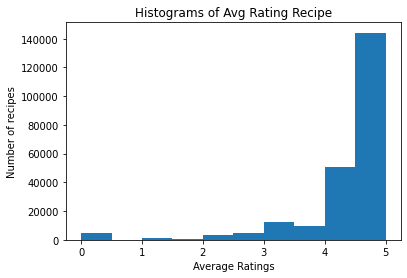

In [7]:
### Interestingly most of the recipes are rated at highest rating. 
interactions.groupby('recipe_id')['rating'].mean().reset_index().rating.plot(kind ='hist',title='Histograms of Avg Rating Recipe')
plt.xlabel("Average Ratings")
plt.ylabel("Number of recipes")
plt.show()

In [8]:
### We will restrict our analysis only to those recipes which has been reviewed by more than 2 people
### Analysis have shown that most recipes are only added but never seen
### Print for the poc purposes we will restrict
g = {'rating' : ['mean'],'user_id' : ['nunique']}
int_summary = interactions.groupby(['recipe_id']).agg(g).reset_index()
### Its gives a muti index output convert it to single index by cobining bothe level
ind = pd.Index([e[0] + "_" +e[1] for e in int_summary.columns.tolist()])
### Assign the column names 
int_summary.columns = ind
int_summary.columns = ['recipe_id', 'rating_mean', 'user_id_nunique']
### We will keep only those recipes in considerstaion which have been reviewed by more than 2 people
int_summary_94k = int_summary[ (int_summary['user_id_nunique'] > 2)]

In [9]:
recipes = pd.read_csv('../input/food-com-recipes-and-user-interactions/RAW_recipes.csv')
print (recipes.columns)

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')


In [10]:
filter_recipe = pd.merge(recipes,int_summary_94k,right_on = ['recipe_id'],left_on = ['id'],how = 'inner')

In [12]:
filter_recipe=filter_recipe[0:10000]
filter_recipe.head(10)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,recipe_id,rating_mean,user_id_nunique
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,137739,5.000000,3
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,31490,3.500000,4
2,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9,75452,4.400000,5
3,better than sex strawberries,42198,1460,41531,2002-10-03,"['weeknight', 'time-to-make', 'course', 'main-...","[734.1, 66.0, 199.0, 10.0, 10.0, 117.0, 28.0]",8,['crush vanilla wafers into fine crumbs and li...,simple but sexy. this was in my local newspape...,"['vanilla wafers', 'butter', 'powdered sugar',...",7,42198,3.800000,5
4,better then bush s baked beans,67547,2970,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,['in a very large sauce pan cover the beans an...,i'd have to say that this is a labor of love d...,"['great northern bean', 'chicken bouillon cube...",13,67547,3.900000,10
5,chicken lickin good pork chops,63986,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,"['dredge pork chops in mixture of flour , salt...",here's and old standby i enjoy from time to ti...,"['lean pork chops', 'flour', 'salt', 'dry must...",7,63986,4.368421,19
6,chile rellenos,43026,45,52268,2002-10-14,"['60-minutes-or-less', 'time-to-make', 'course...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"['drain green chiles', 'sprinkle cornstarch on...",a favorite from a local restaurant no longer i...,"['egg roll wrap', 'whole green chilies', 'chee...",5,43026,4.045455,22
7,chinese candy,23933,15,35268,2002-03-29,"['15-minutes-or-less', 'time-to-make', 'course...","[232.7, 21.0, 77.0, 4.0, 6.0, 38.0, 8.0]",4,['melt butterscotch chips in heavy saucepan ov...,"a little different, and oh so good. i include ...","['butterscotch chips', 'chinese noodles', 'sal...",3,23933,4.833333,12
8,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...","[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,"['celery', 'onion', 'ground pork', 'soy sauce'...",7,8559,2.000000,4
9,cream of spinach soup,76808,45,95743,2003-11-17,"['60-minutes-or-less', 'time-to-make', 'course...","[126.0, 11.0, 2.0, 14.0, 5.0, 23.0, 4.0]",9,"['bring water and salt to a boil', 'cut the po...","wonderful comfort food from rozanne gold, a fa...","['water', 'salt', 'boiling potatoes', 'fresh s...",8,76808,4.666667,3


In [41]:
import numpy as np
phrase_to_list = np.empty(len(filter_recipe), dtype=object)
for i in range (0,len(filter_recipe)):
  T1=recipes['ingredients'][i]
  T1=T1.replace('[', '')
  T1=T1.replace(']', '')
  phrase_to_list[i] = T1
df = pd.DataFrame(phrase_to_list, columns = ['ingredients'])
filter_recipe['ingredients'] = df['ingredients'].values

In [42]:
filter_recipe['ingredients'] = filter_recipe['ingredients'].apply(lambda x : " ".join(ast.literal_eval(x)))


In [43]:
encodings_ing= model.encode(filter_recipe['ingredients'])
#Pickle embedding as it has a run time
pickle.dump(encodings_ing,open("ing_embedding.pickle",'wb'))

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [44]:
encodings_ing_df = pickle.load(open("ing_embedding.pickle",'rb'))
print ("Encoding are loaded")
ing_data_encoding = pd.DataFrame(encodings_ing_df)

Encoding are loaded


In [45]:
ing_encoding_sparse = sparse.csr_matrix(encodings_ing_df[0:5000])

In [47]:
import datetime
time = datetime.datetime.now()
print (time)
ing_similarities_sparse = cosine_similarity(ing_encoding_sparse)
# print('pairwise sparse output:\n {}\n'.format(similarities_sparse))
print ("Time taken is :",)
print (datetime.datetime.now()-time)

2022-11-22 06:07:57.353135
Time taken is :
0:01:57.629178


In [48]:
ing_df1 = pd.DataFrame(ing_similarities_sparse)
pickle.dump(ing_df1,open('ing_similarities_sparse.pickle','wb'))

In [69]:
ing_df1 = pickle.load(open('ing_similarities_sparse.pickle','rb'))
ing_data_similarity = ing_df1.unstack().reset_index() 

In [70]:
ing_data_similarity.columns = ['ingredient1','ingredient2','cosine_similarity']

In [71]:
ing_data_similarity = ing_data_similarity[ing_data_similarity['cosine_similarity']<0.9999]

In [72]:
ing_data_similarity.shape

(24994992, 3)

In [73]:
ingredient_dict = {}
for j,i in enumerate(filter_recipe['ingredients']):
    ingredient_dict[j] = i
print ("Dictionary is created :")

Dictionary is created :


In [75]:
ing_data_similarity['ingredient1_name'] = ing_data_similarity['ingredient1'].map(ingredient_dict)
ing_data_similarity['ingredient2_name'] = ing_data_similarity['ingredient2'].map(ingredient_dict)

In [76]:
ing_data_similarity.head(5)

,ingredient1,ingredient2,cosine_similarity,ingredient1_name,ingredient2_name
1,0,1,0.477934,winter squash mexican seasoning mixed spice ho...,prepared pizza crust sausage patty eggs milk s...
2,0,2,0.626966,winter squash mexican seasoning mixed spice ho...,ground beef yellow onions diced tomatoes tomat...
3,0,3,0.538589,winter squash mexican seasoning mixed spice ho...,spreadable cheese with garlic and herbs new po...
4,0,4,0.552394,winter squash mexican seasoning mixed spice ho...,tomato juice apple cider vinegar sugar salt pe...
5,0,5,0.401723,winter squash mexican seasoning mixed spice ho...,milk vanilla ice cream frozen apple juice conc...


In [77]:
ing_data_similarity['similarity_rank'] = ing_data_similarity.groupby(['ingredient1'])['cosine_similarity'].rank("dense", ascending=False)

In [78]:
ing_data_similarity = ing_data_similarity[ing_data_similarity['similarity_rank'] <= 5].reset_index()

In [79]:
G1 = nx.from_pandas_edgelist(ing_data_similarity,'ingredient1_name','ingredient2_name')

In [81]:
data_sample = ing_data_similarity
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(200,200))
plt.rcParams['axes.facecolor'] ='white'
G1 = nx.Graph()
for i in range(0,5000):
    G1.add_edge(data_sample['ingredient1_name'][i], data_sample['ingredient2_name'][i], weight=data_sample['cosine_similarity'][i])

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.8]


pos = nx.spring_layout(G1)  # positions for all nodes


nx.draw_networkx_nodes(G1, pos, node_size=50)


nx.draw_networkx_edges(G1, pos, edgelist=elarge,     width=5)


nx.draw_networkx_labels(G1, pos, font_size=10, font_family='sans-serif')
#plt.savefig("Network.pdf", bbox_inches='tight')
plt.axis('off')
plt.show()

KeyError: '60-minutes-or-less time-to-make course main-ingredient cuisine preparation occasion north-american side-dishes vegetables mexican easy fall holiday-event vegetarian winter dietary christmas seasonal squash'